## 本文档用于图像与城市语义特征的聚类分析，包含以下关键步骤：

### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量
- 图像数据来源于 patch 周边的城市形态渲染图
- 城市语义向量包括地理加权回归得到的权重指标，用于增强聚类的空间语义表达

### 2. 特征处理：使用卷积神经网络（CNN）提取图像特征向量
- 可使用预训练模型（如 ResNet、VGG）提取高维图像嵌入
- 对语义向量进行标准化处理后拼接进图像特征

### 3. 聚类前评估：使用平均轮廓系数法（Silhouette Score）评估最优聚类数 K
- 遍历不同 K 值，绘制轮廓系数曲线
- 选择得分最高或变化平稳的 K 作为最终聚类数

### 4. 降维与可视化：使用主成分分析（PCA）对高维特征进行 2D 或 3D 映射
- 降维后绘制散点图，查看不同聚类的空间分布
- 分析各主成分的含义（如城市形态 vs. 功能语义）

### 5. 聚类分析：应用 KMeans 等聚类算法对图像+语义向量进行聚类
- 保存聚类标签，评估每类的代表性与空间分布

### 6. 聚类结果输出与解释
- 将聚类标签映射回原始 patch 图像与 GeoDataFrame 中
- 可视化聚类分布、类别图像示例、以及与城市变量的关系

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon,Point
import os


#### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量

In [20]:
def square_buffer(center_point, half_size=500):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

building = gpd.read_file("processing_data/img/building_black").to_crs(epsg=32632)
farming = gpd.read_file("processing_data/img/farming_green").to_crs(epsg=32632)
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)
road = gpd.read_file("processing_data/img/road_grey").to_crs(epsg=32632)
water = gpd.read_file("processing_data/img/water_blue").to_crs(epsg=32632)

processing_center = processing.unary_union.centroid

output_dir = "playground/Render_Images"
output_dir = "playground/Render_Images_2"
os.makedirs(output_dir, exist_ok=True)


# 4. 渲染函数：以一个点为中心，裁剪5km范围并渲染图像
def render_one_image(center_point, index):
    buffer = square_buffer(center_point, half_size=250)  # 250m 半径 = 500m 宽正方形

    def clip_layer(gdf): return gdf[gdf.geometry.intersects(buffer)]

    bld_clip = clip_layer(building)
    farm_clip = clip_layer(farming)
    proc_clip = clip_layer(processing)
    road_clip = clip_layer(road)
    water_clip = clip_layer(water)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor("white")

    # 顺序渲染
    water_clip.plot(ax=ax, color='blue', edgecolor='none')
    farm_clip.plot(ax=ax, color='green', edgecolor='none')
    road_clip.plot(ax=ax, color='grey', linewidth=5)
    bld_clip.plot(ax=ax, color='black', edgecolor='none')
    proc_clip.plot(ax=ax, color='red')

    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"render_{index:03d}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # 5. 遍历 processing 图层的每个 geometry（通常是 Polygon 或 Point）
for idx, row in processing.iterrows():
    center = row.geometry.centroid
    render_one_image(center, idx)

print(f"✅ 共生成 {len(processing)} 张图，保存在 {output_dir}/ 中")

C:\Users\Elena\AppData\Local\Temp\ipykernel_26232\1049499707.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  processing_center = processing.unary_union.centroid
C:\Users\Elena\AppData\Local\Temp\ipykernel_26232\1049499707.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_26232\1049499707.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_26232\1049499707.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_26232\1049499707.py:36: UserWarning: The GeoDataFrame you are attempting 

✅ 共生成 60 张图，保存在 playground/Render_Images_2/ 中


In [21]:
from PIL import Image
import numpy as np
import os

image_folder = "playground\Render_Images_2"
img_list = []

for i in range(60):
    img = Image.open(os.path.join(image_folder, f"render_{i:03d}.png")).resize((224, 224)).convert("RGB")
    img_array = np.array(img) / 255.0
    img_list.append(img_array)

img_array_all = np.stack(img_list)  # shape: (103, 224, 224, 3)

### 获取城市语义

In [127]:
patches_with_gwr = gpd.read_file("processing_data/patches_with_gwr")
print(patches_with_gwr)
from sklearn.preprocessing import StandardScaler
# 原始变量字段
raw_cols = [
    'farming_ar', 'aquacultur', 'pasture_ar', 'energy_are', 'transporta',
    'retail_cou', 'public_ser', 'road_lengt','built_area','entropy_pr', 'entropy_la'
]

# 对应的 GWR β 字段（名称与你的一致）
beta_cols = [
    'beta_farmi', 'beta_aquac', 'beta_pastu', 'beta_energ', 'beta_trans',
    'beta_retai', 'beta_publi', 'beta_road_', 'beta_built', 'beta_entro', 'beta_ent_1'
]
# 逐列相乘得到“机制语义向量”
mechanism_features = []


for raw, beta in zip(raw_cols, beta_cols):
    raw_val = patches_with_gwr[raw].astype(float)
    beta_val = patches_with_gwr[beta].astype(float)
    beta_scaled = StandardScaler().fit_transform(beta_val.values.reshape(-1, 1)).flatten()
    contribution = raw_val * beta_scaled
    mechanism_features.append(contribution)

# 拼接成新的 DataFrame
X_mechanism = np.stack(mechanism_features, axis=1)
print(X_mechanism)

    farming_ar  aquacultur  pasture_ar  energy_are  transporta  retail_cou  \
0     0.462035    0.000000    0.000000    0.000000    0.000000    0.071429   
1     0.797723    0.000000    0.171819    0.000000    0.000000    0.000000   
2     0.522734    0.000000    0.097217    0.000000    0.000000    0.000000   
3     0.415405    0.000000    0.058494    0.000343    0.000000    0.000000   
4     0.743823    0.013290    0.132543    0.000000    0.000000    0.000000   
5     0.762860    0.000000    0.000000    0.000000    0.000000    0.000000   
6     0.675548    0.000000    0.328564    0.000000    0.000000    0.000000   
7     0.509745    0.000000    0.022009    0.000000    0.000000    0.000000   
8     0.573781    0.000000    0.144516    0.276267    0.071526    0.000000   
9     0.640488    0.000000    0.000000    0.000000    0.000000    0.000000   
10    0.403841    0.000000    0.131605    0.000000    0.000000    0.000000   
11    0.556943    0.000000    0.000000    0.000000    0.000000  

#### 利用CNN把图像压缩为512维度

In [128]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# 使用预训练的 ResNet18 来提取图像特征 embedding
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # 去掉分类头，保留特征输出
model.eval()

# 转换图像为 tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

features = []

with torch.no_grad():
    for img in img_list:
        x = transform(Image.fromarray((img * 255).astype(np.uint8)))
        x = x.unsqueeze(0)  # batch 维度
        feat = model(x).squeeze().numpy()
        features.append(feat)

X = np.stack(features)  # shape: (60, 512)

print(X.shape)
print(X)

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(60, 512)
[[0.1930216  0.16416918 2.4361699  ... 0.15482585 0.02584963 0.3264704 ]
 [0.268315   0.2558273  1.4088668  ... 0.534149   0.07571428 1.0670953 ]
 [0.08688277 0.10905307 1.6093038  ... 1.2071517  0.08676451 0.76912946]
 ...
 [0.37315035 0.42304003 1.1014105  ... 0.71274304 0.00415024 0.25130448]
 [1.6888952  0.24211459 1.7155275  ... 1.2678446  0.29170108 1.0751705 ]
 [0.37571013 0.11758512 1.3025566  ... 0.759804   0.53877467 0.48117027]]


In [129]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11)
X_pca = pca.fit_transform(X)
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
print(X_pca)  # 应为 (60, 2)

[[ 1.605288    0.03649398]
 [-0.01691319  1.5335544 ]
 [-0.9071953   1.0895878 ]
 [ 0.40691775  0.04821039]
 [-0.8677056  -1.2793413 ]
 [-0.18655418  1.7720201 ]
 [-1.6296384  -0.72082305]
 [ 0.47480994 -0.62679595]
 [ 0.7944897  -0.10706035]
 [-0.31216204 -0.86311674]
 [-0.38829893 -2.2599974 ]
 [ 0.12355991  2.3864539 ]
 [ 1.2861975   0.74321455]
 [ 0.18114766 -0.7769457 ]
 [ 0.6160516  -1.222946  ]
 [-0.3952789  -0.73775655]
 [ 0.14243785 -0.06540368]
 [ 2.0993977   1.6889133 ]
 [-0.62256473  0.4044275 ]
 [-0.6411895  -0.45639807]
 [-0.836144    0.12027957]
 [ 1.1629848  -0.61854315]
 [ 0.13923164  0.5462508 ]
 [-0.0362874   0.5623874 ]
 [ 0.8910622  -0.02280605]
 [ 1.1862676  -0.79252046]
 [-0.4499192   1.3830734 ]
 [ 1.7001668   0.04402447]
 [-0.09642414  1.0898858 ]
 [ 0.89616656  0.7094703 ]
 [ 1.3055902  -1.2058339 ]
 [ 1.2016822  -1.8042946 ]
 [-0.21931145 -0.04480704]
 [ 0.4653132  -1.3082552 ]
 [ 0.73260933 -1.2781839 ]
 [ 0.19346859 -0.37150577]
 [-1.8576162  -1.0948977 ]
 

In [130]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(X_mechanism)
X_final= np.hstack([X_pca, X_mechanism])
print(X_final.shape)
print(X_final)

(60, 13)
[[ 1.60528803e+00  3.64939794e-02 -7.27954583e-01 -0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.85165658e-03
   0.00000000e+00 -1.20849309e-02 -5.46083165e-01  2.66842134e-09
   1.49203220e-01]
 [-1.69131923e-02  1.53355443e+00 -2.06039899e-02 -0.00000000e+00
   3.15744383e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -1.13437856e-02  1.23718828e-02 -9.58880145e-02
   6.02067826e-04]
 [-9.07195330e-01  1.08958781e+00 -8.23587384e-01  0.00000000e+00
   1.70994751e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -3.18239334e-03 -1.15902504e+00
  -1.07832087e-10]
 [ 4.06917751e-01  4.82103936e-02 -1.07292831e-02 -0.00000000e+00
   1.07491539e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -1.32757647e-02  3.44003528e-02 -7.67080577e-02
   8.88106128e-02]
 [-8.67705584e-01 -1.27934134e+00 -1.92118231e-02 -8.23743576e-04
   2.43568646e-02 -0.00000000e+00 -0.00000000e+00 -0.0000

#### 利用平均轮廓系数找到最佳的 K 值

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

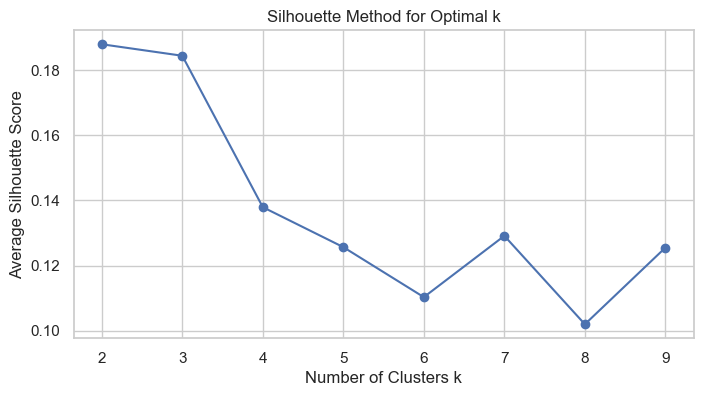

In [131]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

# 你已经提取好了高维特征向量 X（比如 CNN+GWR 合并向量）

sil_scores = []
K_range = range(2, 10)  # 可自定义聚类数尝试范围

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
#     score = silhouette_score(X, kmeans.labels_)
#     sil_scores.append(score)

for k in K_range:
    try:
        clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels = clustering.fit_predict(X_final)
        score = silhouette_score(X_final, labels)
        sil_scores.append(score)
    except Exception as e:
        sil_scores.append(np.nan)
        print(f"k={k} 失败: {e}")
# 可视化平均轮廓系数
plt.figure(figsize=(8, 4))
plt.plot(K_range, sil_scores, 'bo-')
plt.xlabel("Number of Clusters k")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True)
plt.show()


D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


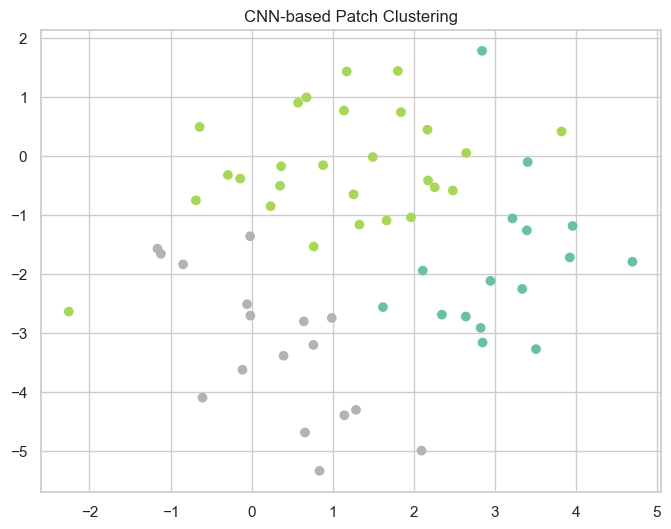

In [132]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering

n_clusters = 3 # 你可以试着调成 3～6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_final)
# clustering = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
# labels = clustering.fit_predict(X)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_final)
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='Set2')
plt.title("CNN-based Patch Clustering")
plt.show()


# # 画3D散点图
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_final[:, 0], X_final[:, 1], X_final[:, 2],
#                      c=labels, cmap='Set2', s=40)
#
# # 添加标签
# ax.set_title("3D PCA of CNN-based Patch Clustering")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
#
# # 可选：加图例
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)
#
# plt.tight_layout()
# plt.show()

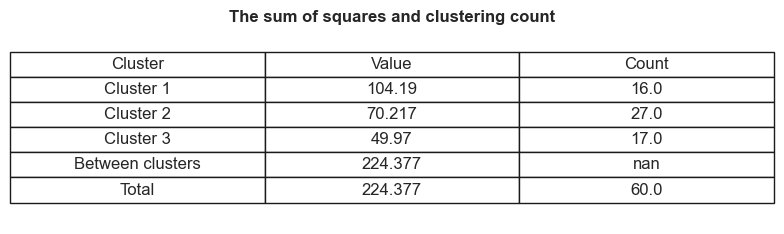

In [133]:
import pandas as pd
import numpy as np

# 初始化列表
cluster_ids = np.unique(labels)
data = []

for cluster_id in cluster_ids:
    # 选中该类所有样本
    cluster_points = X_final[labels == cluster_id]

    # 获取该类的质心
    center = kmeans.cluster_centers_[cluster_id]

    # 计算组内平方误差：∑‖xi - center‖²
    sse = np.sum(np.linalg.norm(cluster_points - center, axis=1) ** 2)

    data.append({
        "Cluster": f"Cluster {cluster_id + 1}",
        "Value": round(sse, 3),
        "Count": len(cluster_points)
    })

# 计算整体指标
total_sse = np.sum([d["Value"] for d in data])
between_sse = kmeans.inertia_  # 注意：inertia_ 是总的 WCSS，不是 between

# 构造 DataFrame
df = pd.DataFrame(data)

# 可选：加上整体统计行
df.loc[len(df)] = ["Between clusters", round(between_sse, 3), ""]
df["Count"] = pd.to_numeric(df["Count"], errors='coerce')
df.loc[len(df)] = ["Total", round(total_sse, 3), df["Count"].sum()]

# 展示表格

import matplotlib.pyplot as plt


# 生成一个空图用于放表格
plt.figure(figsize=(8, len(df) * 0.5))
plt.axis('off')

# 添加表格内容
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='center')

table.scale(1, 1.5)  # 调整表格大小
plt.title("The sum of squares and clustering count", fontweight="bold")
plt.tight_layout()
plt.show()


In [134]:
import numpy as np

representative_indices = []

for cluster_id in np.unique(labels):
    # 所有该类的索引
    idx = np.where(labels == cluster_id)[0]
    cluster_points = X_final[idx]

    # 该类质心
    center = kmeans.cluster_centers_[cluster_id]

    # 计算每个点与质心的距离
    distances = np.linalg.norm(cluster_points - center, axis=1)

    # 距离最小的点是代表点
    min_idx_within_cluster = np.argmin(distances)
    rep_idx = idx[min_idx_within_cluster]
    representative_indices.append(rep_idx)

print("代表图片索引为:", representative_indices)


代表图片索引为: [40, 35, 50]


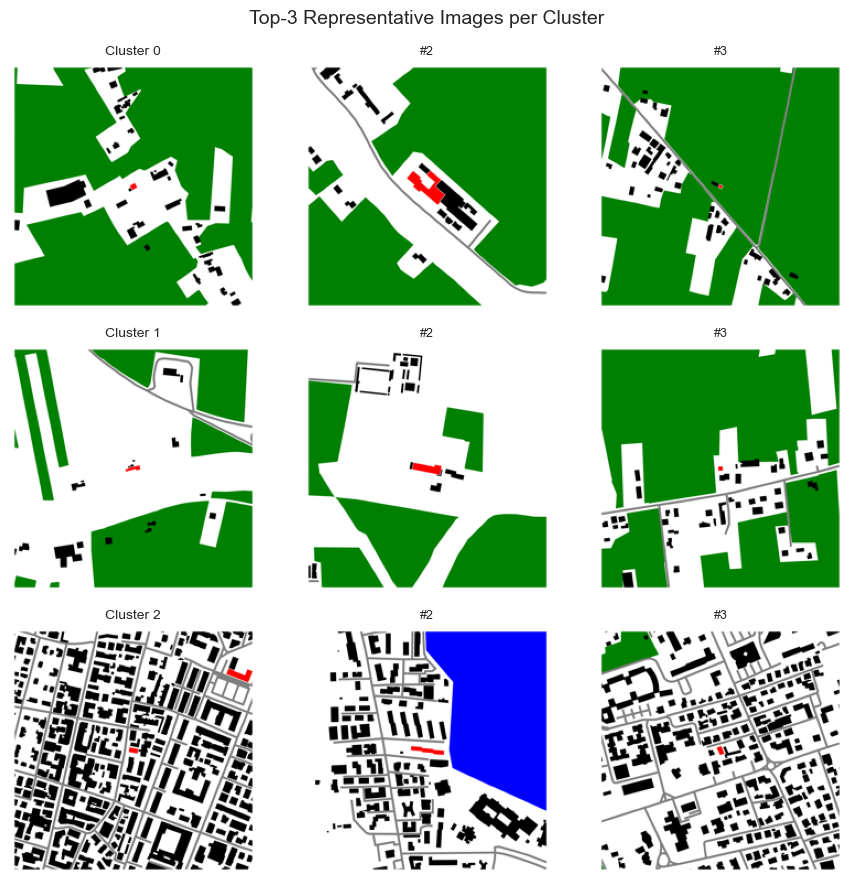

In [135]:
import matplotlib.pyplot as plt

topk = 3
representative_clusters = {}

for cluster_id in np.unique(labels):
    idx = np.where(labels == cluster_id)[0]
    cluster_points = X_final[idx]
    center = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_points - center, axis=1)

    sorted_indices = idx[np.argsort(distances)[:topk]]
    representative_clusters[cluster_id] = sorted_indices

topk = 3  # 你已经设定为 3
n_clusters = len(representative_clusters)

plt.figure(figsize=(topk * 3, n_clusters * 3))

for cluster_id, indices in representative_clusters.items():
    for rank, idx in enumerate(indices):
        plt_idx = cluster_id * topk + rank + 1  # subplot index
        plt.subplot(n_clusters, topk, plt_idx)
        img = img_list[idx]

        # 若图像归一化（0~1），需要乘回 255
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.axis("off")
        if rank == 0:
            plt.title(f"Cluster {cluster_id}", fontsize=10)
        else:
            plt.title(f"#{rank+1}", fontsize=9)

plt.suptitle("Top-3 Representative Images per Cluster", fontsize=14)
plt.tight_layout()
plt.show()
